Fetching latest data for AAPL...
Done. Current Spot Price: $226.67

--- Running Pricing Models ---

Parameters: K=$200.0, T=0.25yr, r=5.00%, sigma=25.00%
Black–Scholes Price: $30.96
Monte Carlo Price  : $30.92

--- Option Sensitivities (Greeks) ---
Delta               :  0.8778
Gamma               :  0.0072
Vega (per 1% vol)   :  0.2297
Theta (per day)     : -0.0545
Rho (per 1% rate)   :  0.4200


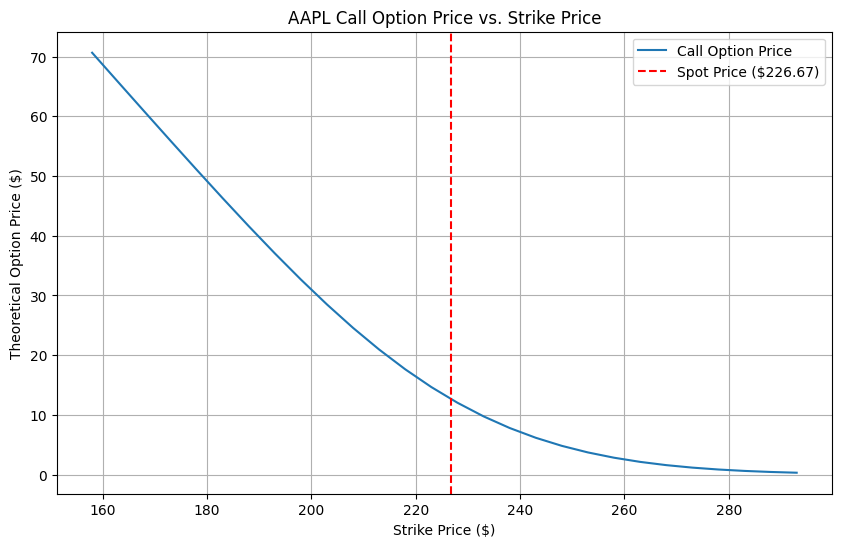

In [1]:
# Options Pricing & Hedging Tool
# Author: Harvey Sohal

!pip install yfinance scipy --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from scipy.optimize import brentq

#PRICING MODELS


def black_scholes(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == "call":
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type.lower() == "put":
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

    return price

def monte_carlo_option(S, K, T, r, sigma, option_type="call", simulations=100000):
    rand_vals = np.random.standard_normal(simulations)
    ST = S * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rand_vals)

    if option_type.lower() == "call":
        payoff = np.maximum(ST - K, 0)
    elif option_type.lower() == "put":
        payoff = np.maximum(K - ST, 0)
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

    return np.exp(-r * T) * np.mean(payoff)

#RISK MANAGEMENT

def calculate_greeks(S, K, T, r, sigma, option_type="call"):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    pdf_d1 = norm.pdf(d1)

    gamma = pdf_d1 / (S * sigma * np.sqrt(T))
    vega = (S * pdf_d1 * np.sqrt(T)) / 100

    if option_type.lower() == "call":
        delta = norm.cdf(d1)
        theta_annual = -(S * pdf_d1 * sigma) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)
        rho = (K * T * np.exp(-r * T) * norm.cdf(d2)) / 100
    elif option_type.lower() == "put":
        delta = norm.cdf(d1) - 1
        theta_annual = -(S * pdf_d1 * sigma) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2)
        rho = (-K * T * np.exp(-r * T) * norm.cdf(-d2)) / 100
    else:
        raise ValueError("Invalid option type. Choose 'call' or 'put'.")

    greeks = {
        "Delta": delta,
        "Gamma": gamma,
        "Vega (per 1% vol)": vega,
        "Theta (per day)": theta_annual / 365,
        "Rho (per 1% rate)": rho
    }
    return greeks

#IMPLIED VOLATILITY

def implied_volatility(market_price, S, K, T, r, option_type="call"):
    objective_func = lambda sigma: black_scholes(S, K, T, r, sigma, option_type) - market_price
    try:
        return brentq(objective_func, 1e-4, 5.0)
    except ValueError:
        return np.nan


# EXAMPLE USAGE

def run_analysis():
    ticker = "AAPL"
    option_type = "call"
    strike_price = 200.0
    time_to_expiry_years = 0.25
    risk_free_rate = 0.05
    assumed_volatility = 0.25

    print(f"Fetching latest data for {ticker}...")
    stock_data = yf.Ticker(ticker)
    spot_price = stock_data.history(period="1d")["Close"].iloc[-1]
    print(f"Done. Current Spot Price: ${spot_price:.2f}")

    print("\n--- Running Pricing Models ---")
    bs_price = black_scholes(spot_price, strike_price, time_to_expiry_years, risk_free_rate, assumed_volatility, option_type)
    mc_price = monte_carlo_option(spot_price, strike_price, time_to_expiry_years, risk_free_rate, assumed_volatility, option_type)
    greeks = calculate_greeks(spot_price, strike_price, time_to_expiry_years, risk_free_rate, assumed_volatility, option_type)

    print(f"\nParameters: K=${strike_price}, T={time_to_expiry_years}yr, r={risk_free_rate:.2%}, sigma={assumed_volatility:.2%}")
    print(f"Black–Scholes Price: ${bs_price:.2f}")
    print(f"Monte Carlo Price  : ${mc_price:.2f}")

    print("\n--- Option Sensitivities (Greeks) ---")
    for greek, value in greeks.items():
        print(f"{greek:<20}: {value: .4f}")

    strike_range = np.arange(int(spot_price * 0.7), int(spot_price * 1.3), 5)
    prices = [black_scholes(spot_price, k, time_to_expiry_years, risk_free_rate, assumed_volatility) for k in strike_range]

    plt.figure(figsize=(10, 6))
    plt.plot(strike_range, prices, label=f"{option_type.title()} Option Price")
    plt.axvline(spot_price, color="red", linestyle="--", label=f"Spot Price (${spot_price:.2f})")
    plt.xlabel("Strike Price ($)")
    plt.ylabel("Theoretical Option Price ($)")
    plt.title(f"{ticker} Call Option Price vs. Strike Price")
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Entry point of the script ---
if __name__ == "__main__":
    run_analysis()